In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import time
import itertools
from preprocess import preprocess
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accdate                 497 non-null    float64
 1   Operator_ID             497 non-null    float64
 2   BAITFISHCode            497 non-null    float64
 3   AccPreventable          497 non-null    float64
 4   vehbusno                497 non-null    float64
 5   vehmake                 497 non-null    float64
 6   vehyear                 497 non-null    float64
 7   Drv_Age                 497 non-null    float64
 8   CoDrvSex                497 non-null    float64
 9   Roadway                 497 non-null    float64
 10  RoadwayLightConditions  497 non-null    float64
 11  RoadwayWeather          497 non-null    float64
 12  RoadwaySurface          497 non-null    float64
 13  Addr_Type               497 non-null    float64
 14  Neighborhood            497 non-null    fl

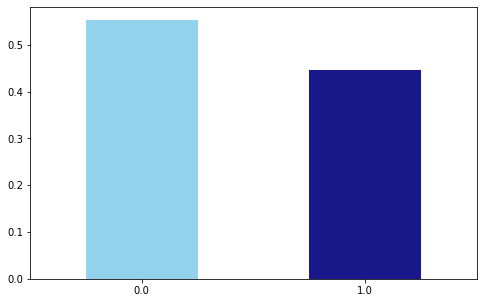

In [9]:
accidents = preprocess('../data/imputed_v2.csv')
print(accidents.info())
      
fig = plt.figure(figsize = (8,5))
accidents.AccPreventable.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.show()

<AxesSubplot:>

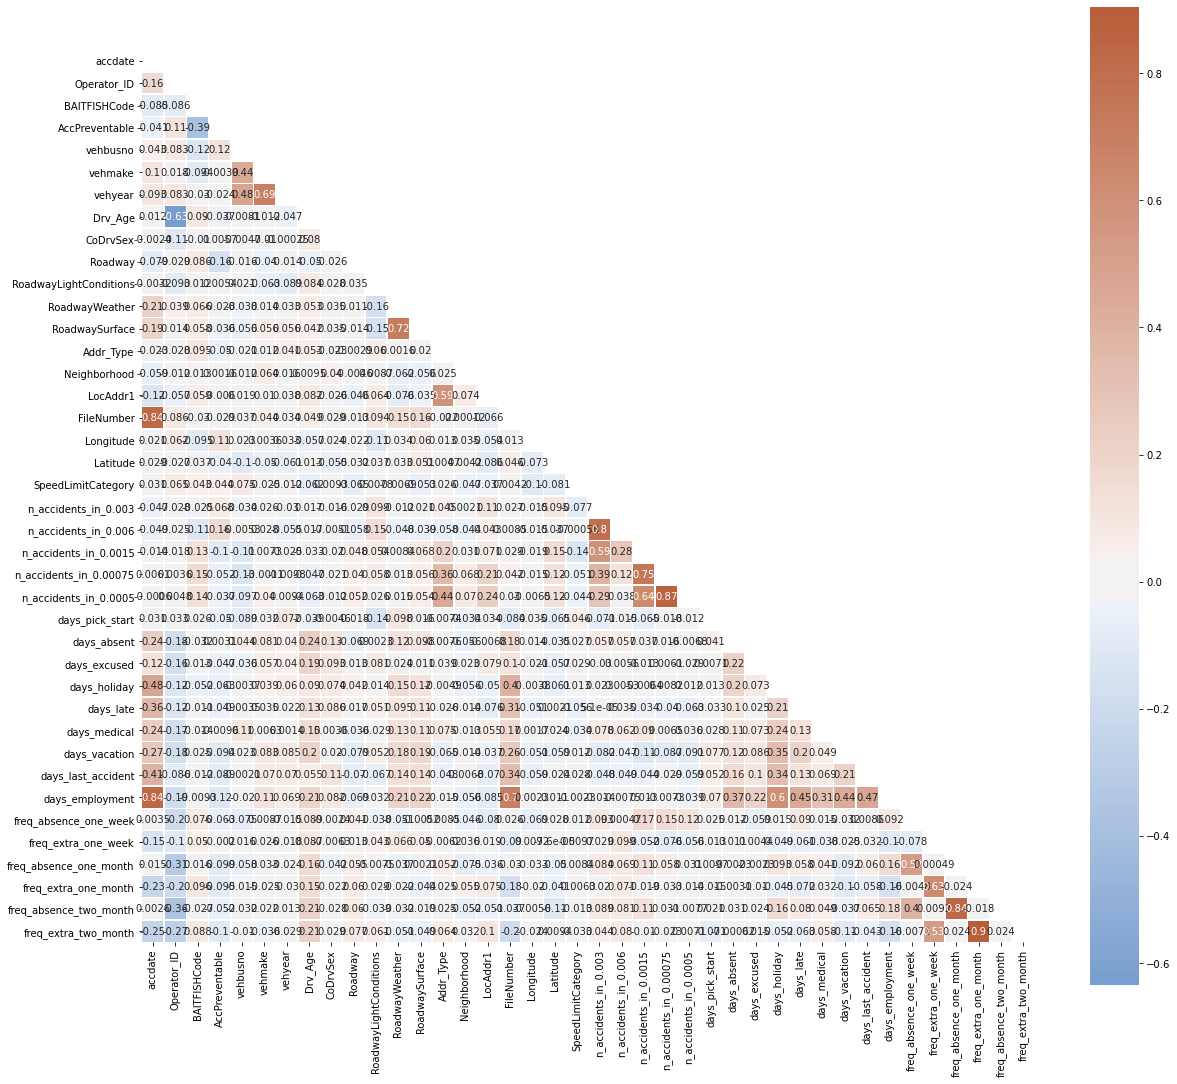

In [3]:
corr = accidents.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [34]:
X = accidents.loc[:,accidents.columns!='AccPreventable']
y = accidents[['AccPreventable']]

In [35]:
# feature selection using filter method
selector = SelectKBest(chi2, k=5)
selector.fit(X, y)
X_select_chi2 = selector.transform(X)

X.columns[selector.get_support(indices=True)]

Index(['BAITFISHCode', 'vehbusno', 'n_accidents_in_0.006',
       'freq_extra_one_month', 'freq_extra_two_month'],
      dtype='object')

In [6]:
# feature selection using tree-based method
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['BAITFISHCode', 'Longitude', 'Latitude', 'n_accidents_in_0.003', 'n_accidents_in_0.006']
[0.01359771 0.02054138 0.49605511 0.01943233 0.00283966 0.00894438
 0.01582747 0.00203099 0.01293878 0.00418138 0.00691321 0.00342548
 0.00202504 0.010657   0.02453517 0.01797195 0.03974622 0.02892005
 0.00591563 0.02899834 0.04333988 0.01671802 0.01168976 0.00931905
 0.02112213 0.01360918 0.01184194 0.0081706  0.00604019 0.00646061
 0.01560814 0.00631959 0.02502577 0.00416148 0.00117464 0.01350695
 0.00348664 0.01134608 0.00556207]


In [7]:
# double check feature importance
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.4362 ± 0.0246,BAITFISHCode
0.0004 ± 0.0016,LocAddr1
0 ± 0.0000,accdate
0 ± 0.0000,vehbusno
0 ± 0.0000,vehmake
0 ± 0.0000,vehyear
0 ± 0.0000,Drv_Age
0 ± 0.0000,CoDrvSex
0 ± 0.0000,Roadway
0 ± 0.0000,RoadwayLightConditions


In [12]:
# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=77)


In [13]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [14]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.88
ROC Area under Curve = 0.8583333333333333
Cohen's Kappa = 0.7413793103448276
Time taken = 0.023012161254882812
              precision    recall  f1-score   support

         0.0    0.85294   0.96667   0.90625        30
         1.0    0.93750   0.75000   0.83333        20

    accuracy                        0.88000        50
   macro avg    0.89522   0.85833   0.86979        50
weighted avg    0.88676   0.88000   0.87708        50



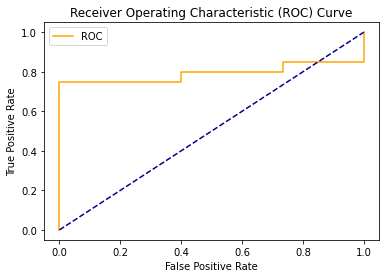

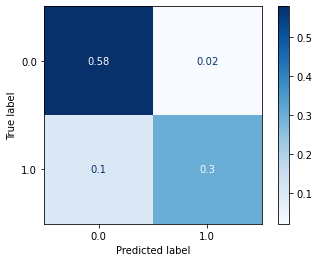

In [15]:
# model 1: Logistic Regression penalized by Lasso
params_lr = {'penalty': 'l1', 'solver':'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.88
ROC Area under Curve = 0.8583333333333333
Cohen's Kappa = 0.7413793103448276
Time taken = 0.0068089962005615234
              precision    recall  f1-score   support

         0.0    0.85294   0.96667   0.90625        30
         1.0    0.93750   0.75000   0.83333        20

    accuracy                        0.88000        50
   macro avg    0.89522   0.85833   0.86979        50
weighted avg    0.88676   0.88000   0.87708        50



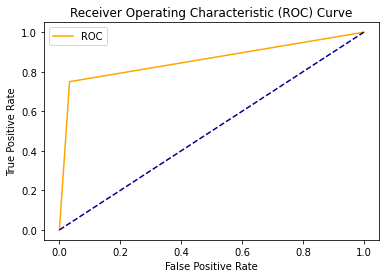

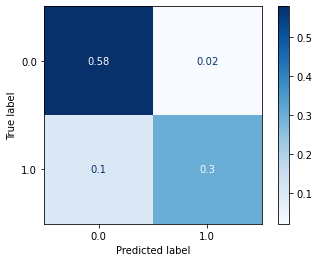

In [16]:
# model 2: decision tree
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Accuracy = 0.96
ROC Area under Curve = 0.95
Cohen's Kappa = 0.9152542372881356
Time taken = 0.15604782104492188
              precision    recall  f1-score   support

         0.0    0.93750   1.00000   0.96774        30
         1.0    1.00000   0.90000   0.94737        20

    accuracy                        0.96000        50
   macro avg    0.96875   0.95000   0.95756        50
weighted avg    0.96250   0.96000   0.95959        50



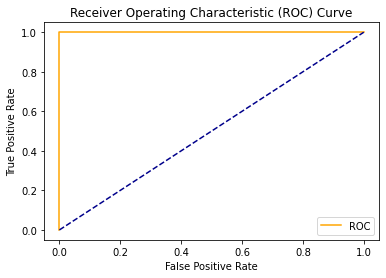

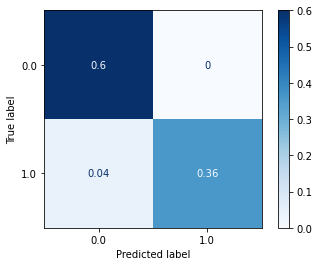

In [23]:
# model 4: random forest
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

Accuracy = 1.0
ROC Area under Curve = 1.0
Cohen's Kappa = 1.0
Time taken = 43.6897919178009
              precision    recall  f1-score   support

         0.0    1.00000   1.00000   1.00000        30
         1.0    1.00000   1.00000   1.00000        20

    accuracy                        1.00000        50
   macro avg    1.00000   1.00000   1.00000        50
weighted avg    1.00000   1.00000   1.00000        50



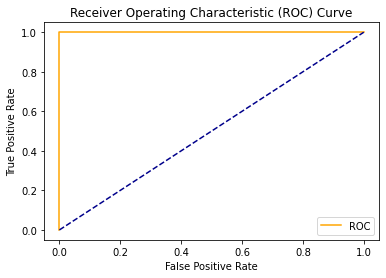

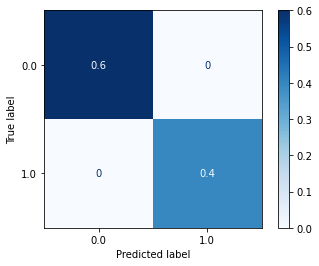

In [24]:
# model 5: catboost
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

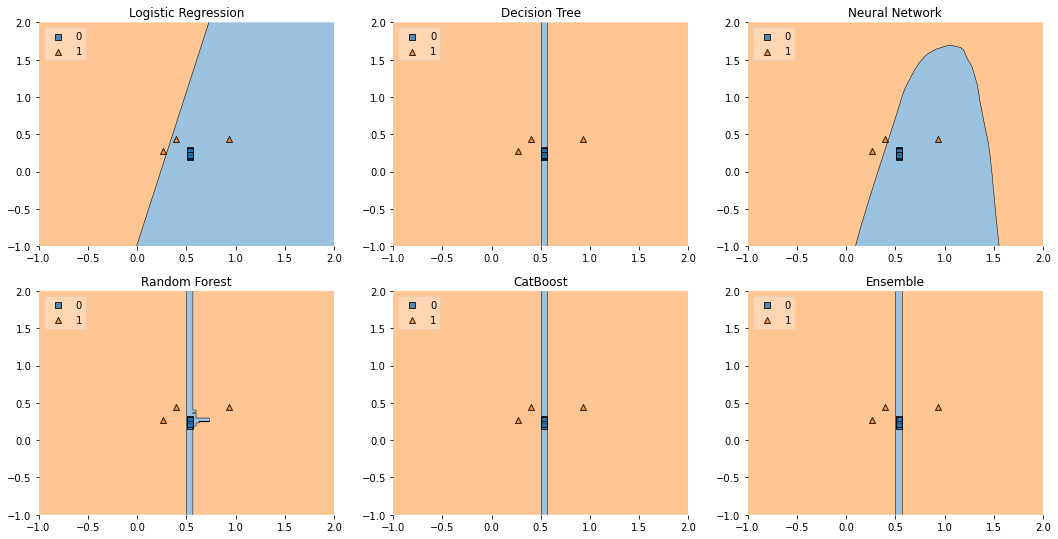

In [40]:
# plot decision boundary
value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5], weights=[1, 1], voting='soft')

X_list = accidents[['BAITFISHCode', 'Longitude', 'Latitude']]
X = np.asarray(X_list, dtype=np.float32)
y_list = accidents['AccPreventable']
y = np.asarray(y_list, dtype=np.int32)

gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'CatBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

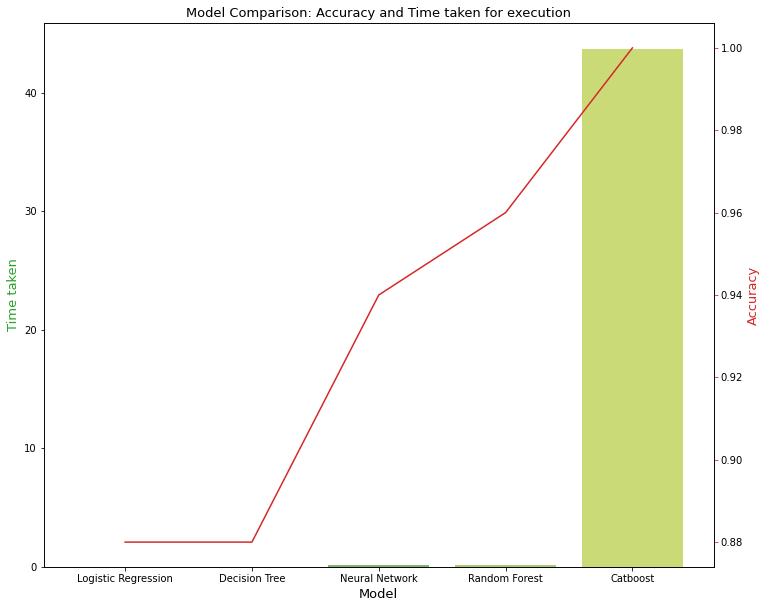

In [43]:
# model comparison
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_cb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_cb ]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_cb ]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_cb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','Catboost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

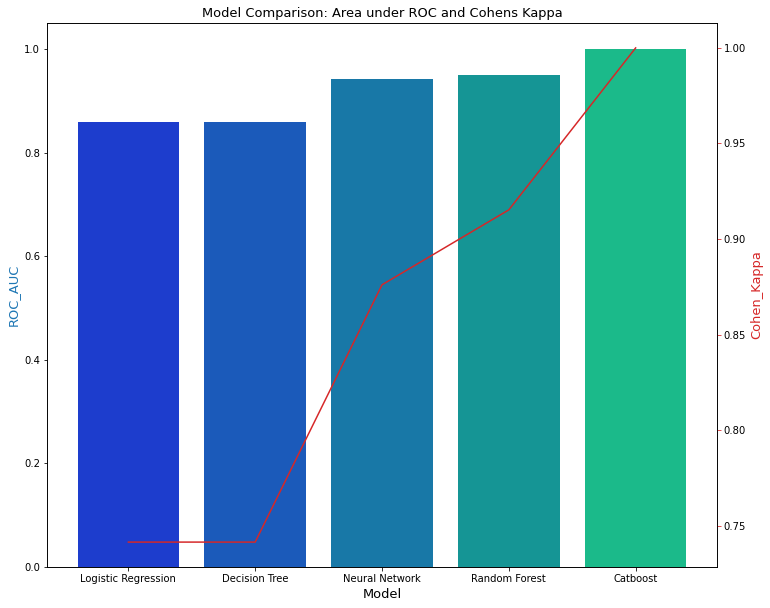

In [44]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()